In [2]:
# Imports
import ufl
import dolfinx
import numpy as np
import matplotlib.pyplot as plt

from fenics import operators as fn
from fenics import express, distributions
from configurations.confs1D import BCs, parametrs, funcs


In [3]:
# Set up and redefine parametrs
DATA = parametrs.Data('test4', '')
_r = DATA.rates
_r.a, _r.b, _r.e, _r.general = 1, 0.1, 0.5, 0.01

DATA.time.line = np.arange(0, 1, 0.001)
DATA.time.check = DATA.time.line[::100]

_l = DATA.light_confs
_l.left, _l.right, _l.type, _l.smoothing = 0.1, 0.6, 'sigmoid', 100

DATA.mesh_confs.intervals = 100
DATA

save_confs  name: test4
save_confs  desc: 
save_confs  file_name: solve
save_confs  dir: /home/Solves/
solver_confs  solve_options: {'convergence': 'incremental', 'tolerance': 1e-06}
solver_confs  petsc_options: {'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps'}
solver_confs  form_compiler_options: {}
solver_confs  jit_options: {}
mesh_confs  intervals: 100
mesh_confs  left: 0
mesh_confs  right: 1
mesh_confs  degree: 1
mesh_confs  family: CG
bcs: {'type': 'close'}
time  line: [0.0, 0.001 .. 0.998, 0.999]; len = 1000
time  check: [0.0, 0.1 .. 0.8, 0.9]; len = 10
rates  a: 1
rates  b: 0.1
rates  e: 0.5
rates  general: 0.01
rates  gamma: 4
light_confs  left: 0.1
light_confs  right: 0.6
light_confs  type: sigmoid
light_confs  smoothing: 100
initial  n: 0.2
initial  p: 0.001

In [4]:
# Set up space

# TODO: Change to another dimension and geometry
domain = fn.mesh.create_interval(
    nx=DATA.mesh_confs.intervals,
    comm=fn.MPI.COMM_WORLD,
    points=[DATA.mesh_confs.left, DATA.mesh_confs.right],
)
mesh_interval = (DATA.mesh_confs.right -
                 DATA.mesh_confs.left) / DATA.mesh_confs.intervals

# TODO: Change to another study and mesh accurancy
elements = {
    'n': ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1),
    'p': ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1),
}
space_data = fn.make_space(domain, elements)
space = space_data['space']
subspace_n, subspace_p = space_data['subspaces']

f1_data = fn.make_functions(space, list(elements.keys()), 1)
func = f1_data['function']
subfunc_n, subfunc_p = f1_data['subfunctions']
n, p = f1_data['variables']

f0_data = fn.make_functions(space, list(elements.keys()), 0)
func0 = f0_data['function']
n0, p0 = f0_data['variables']

x, y, z = space_data['coordinates']
ds = fn.create_ds(domain)
dx = fn.dx

time = fn.Constant(
    subspace_n,
    0,
)
dt = DATA.time.line[1] - DATA.time.line[0]


# Set up equation

## Light
# TODO: Change to another dimension
light = distributions.Simple1D(
    x=x,
    x0=DATA.light_confs.left,
    smoothing=DATA.light_confs.smoothing,
).create(style=DATA.light_confs.type)
light *= distributions.Simple1D(
    x=x,
    x0=DATA.light_confs.right,
    smoothing=-DATA.light_confs.smoothing,
).create(style=DATA.light_confs.type)

## Constants
_r = DATA.rates
gen_rate = _r.general
P_step = _r.P_step
a_nm = gen_rate * _r.a
b_pm = gen_rate * _r.b * fn.exp(-p / P_step)
e_np = gen_rate * _r.e * fn.exp(-p / P_step)

_g = _r.gamma
m = 1 - p - n
_under_ln = m / (1-n)
_power = (_g-1) / _g
reaction = _g * m * (-fn.ln(_under_ln))**_power

## BCs
bcs = []

## Surface fluxes
# surflux_n,surflux_p = BCs.BCs1D.create(
#     style='fixed_flux',
#     value = time
# ),BCs.BCs1D.create(
#     style='fixed_flux',
#     value = time
# )
surflux_n, surflux_p = BCs.BCs1D.create(style='close'), BCs.BCs1D.create(style='close')

## Inside fluxes
flux_n = 0
flux_n += -a_nm * fn.grad(n)
flux_n += +a_nm * p * fn.grad(n)
flux_n += -e_np * p * fn.grad(n)
flux_n += -a_nm * n * fn.grad(p)
flux_n += +e_np * n * fn.grad(p)

flux_P = 0
flux_P += -b_pm * fn.grad(p)
flux_P += +b_pm * n * fn.grad(p)
flux_P += -e_np * n * fn.grad(p)
flux_P += -b_pm * p * fn.grad(n)
flux_P += +e_np * p * fn.grad(n)

## Equation
test_n, test_p = fn.TestFunctions(space)

equation_n = (1/dt) * (n-n0) * test_n * dx
equation_n += -(flux_n|fn.inner|fn.grad(test_n)) * dx
equation_n += test_n * surflux_n * ds

equation_p = (1/dt) * (p-p0) * test_p * dx
equation_p += -(flux_P|fn.dot|fn.grad(test_p)) * dx
equation_p += -light * reaction * test_p * dx
equation_p += test_p * surflux_p * ds
equation = equation_n + equation_p

## Save constants
variables = 'n,p'
saved_expr ={
    'light': express.get_view(light, variables=variables),
    'equation': express.get_view(variables=variables, func=equation),
    'reaction': express.get_view(variables=variables, func=reaction),
    'a_nm': express.get_view(variables=variables, func=a_nm),
    'b_pm': express.get_view(variables=variables, func=b_pm),
    'e_np': express.get_view(variables=variables, func=e_np),
}
DATA({'expressions':saved_expr})


In [5]:
# Set up problem
def make_problem():
    # FIXME: reset bcs
    subfunc_n.interpolate(fn.Function(subspace_n, DATA.initial.n))
    subfunc_p.interpolate(fn.Function(subspace_p, DATA.initial.p))
    func.x.scatter_forward()
    func0.interpolate(func)

    time.value = 0
    return fn.NonlinearProblem(
        equation=equation,
        bcs=bcs,
        func=func,
        **DATA.solver_confs.Options,
    )

problem = make_problem()

light_func = fn.Function(subspace_n, light, 'light')


def save_func(file: dolfinx.io.XDMFFile, time):
    file.write_function(subfunc_n, time)
    file.write_function(subfunc_p, time)
    file.write_function(light_func, time)


def change_func():
    func0.interpolate(func)
    time.value = +dt


solve_opts = dict(
    problem=problem,
    data=DATA,
    change_func=change_func,
    save_func=save_func,
    domain=domain,
)

In [6]:
funcs.SolveTimeDependent_1D(
    save=False,
    time_line=DATA.time.line,
    **solve_opts,
)

Solving PDE. Time:1.00: 100%|██████████| 1000/1000 [00:05<00:00, 187.11it/s]


<AxesSubplot:>

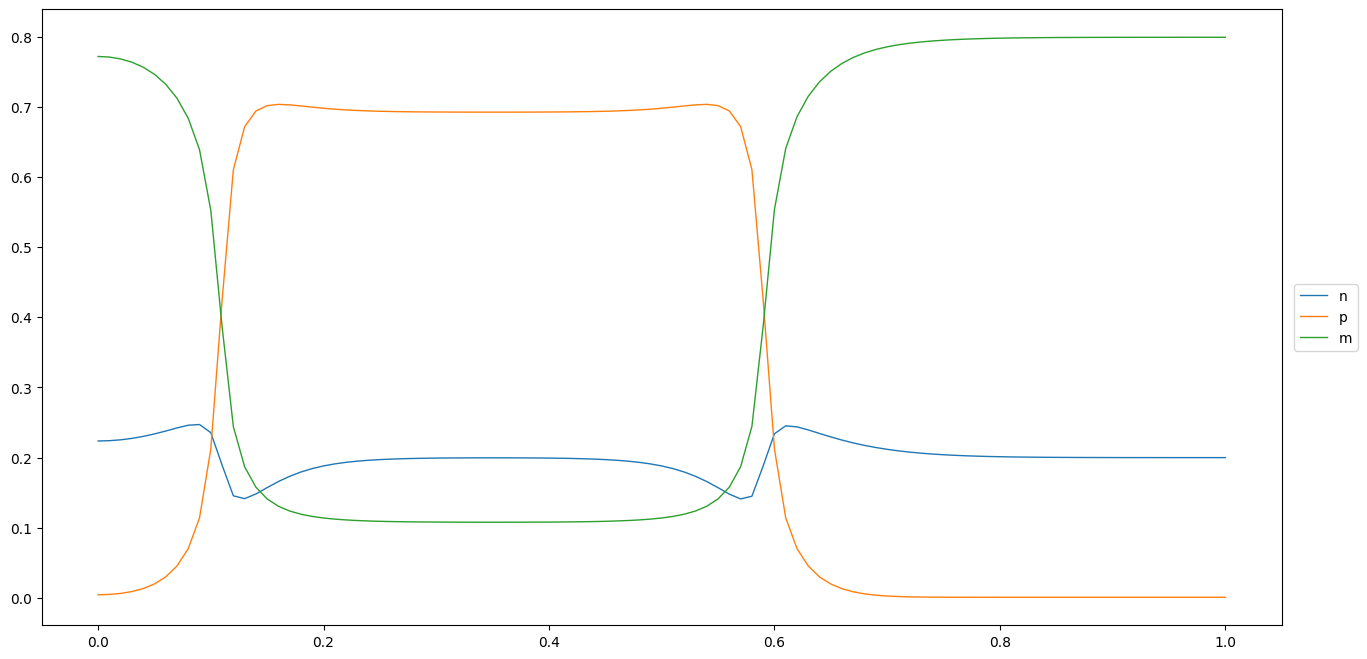

In [7]:
express.func_plot1D([
    fn.Function(space=subspace_n, form=subfunc_n, name='n'),
    fn.Function(space=subspace_p, form=subfunc_p, name='p'),
    fn.Function(space=subspace_n, form=1 - subfunc_p - subfunc_n, name='m'),
])

Rule: Right - left at x=0.35, point = 35


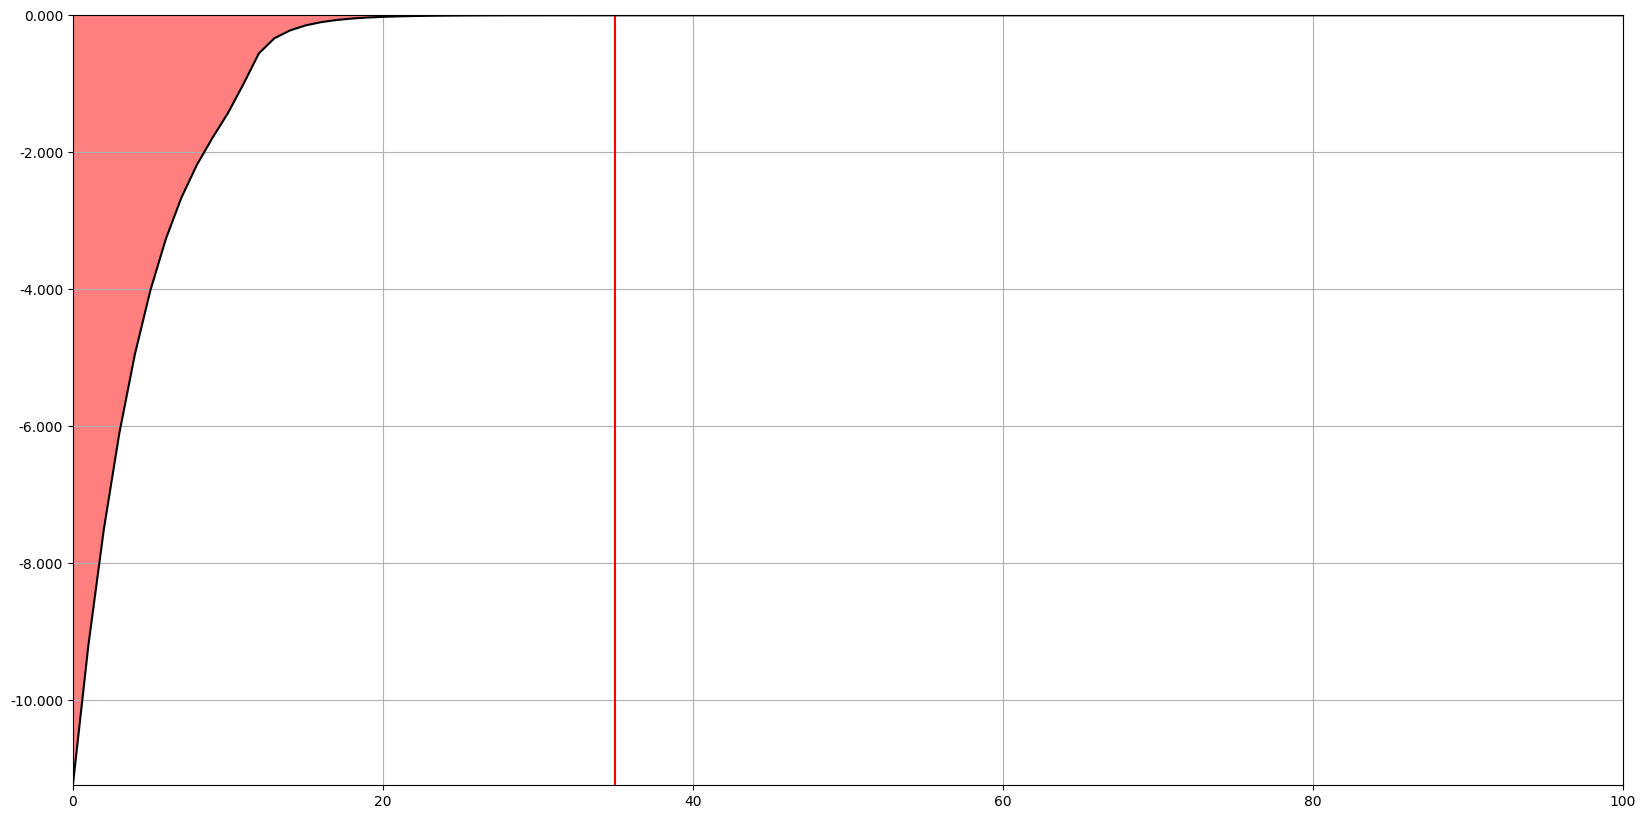

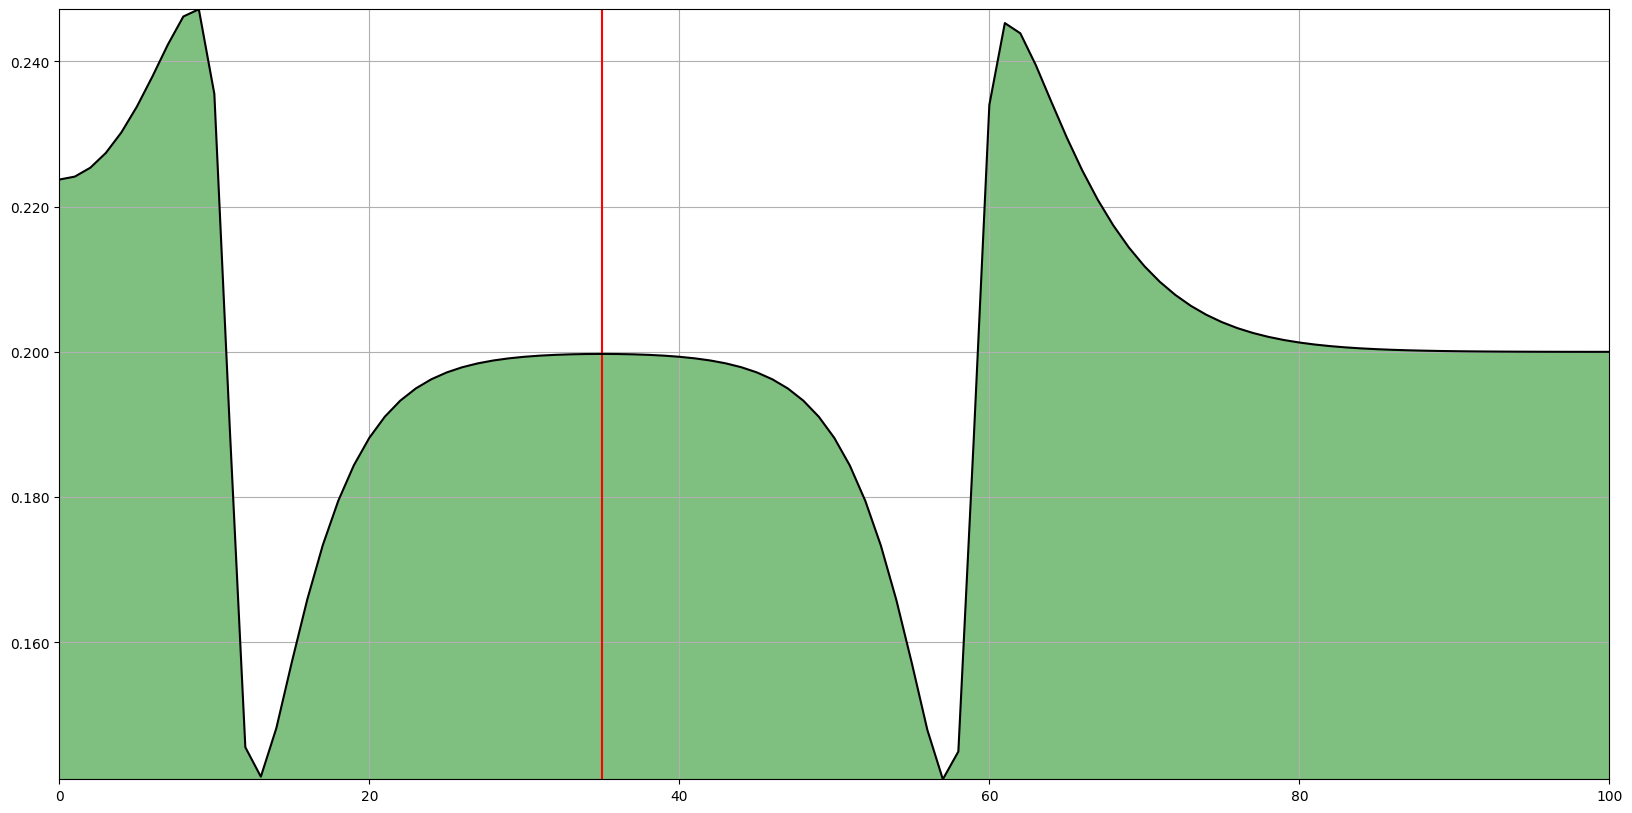

In [8]:
a = express.ArrayFunc(fn.Function(space=subspace_n, form=subfunc_n, name='n'))
a.check_symmetry(x_middle=(DATA.light_confs.right + DATA.light_confs.left) / 2)